# Distributed Data Analytics - Exercise 9(Krithika Murugesan -277537)

Exercise 1: Apache spark basics : Part A

The given lists are stored as RDD and the join operations are used to perform the right outer join, where all elements from first table are taken with matching entries from second table, while full outer join is intersection of all elements. The frequency of character s in both the tables is done using map reduce and aggregate function after joining the two tables together

In [1]:
#import packages
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()

sqlContext = SQLContext(sc)
from pyspark.sql import Row

#Given lists
a = ["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda","parallel","partition"]

#To RDD
rddA = sc.parallelize(a)
rddB = sc.parallelize(b)

A = rddA.map(lambda x: Row(name = x))
B = rddB.map(lambda x: Row(name = x))

schemaA = sqlContext.createDataFrame(A)
schemaB = sqlContext.createDataFrame(B)

print(type(schemaA),type(schemaB))

<class 'pyspark.sql.dataframe.DataFrame'> <class 'pyspark.sql.dataframe.DataFrame'>


In [2]:
#Right outer join
schemaA.join(schemaB, "name" ,"right_outer").show()

+---------+
|     name|
+---------+
|operation|
|   lambda|
|partition|
| parallel|
|    scala|
|   apache|
+---------+



In [3]:
#Full outer join
joined = schemaA.join(schemaB, "name" ,"full_outer")
joined.show()

+---------+
|     name|
+---------+
|operation|
|   lambda|
|  context|
|partition|
|   create|
|      rdd|
| parallel|
|    scala|
|   apache|
|    spark|
|    class|
|   python|
+---------+



In [4]:
#Map reduce : frequncy of s,where map counts s in seperate parts and reduce sums it
joined.show()
count = joined.rdd.map(lambda x: sum([each.count('s') for each in x]))
                                                .reduce(lambda x, y: x + y)
print("No: of 's' in Schema A and B ",count)

+---------+
|     name|
+---------+
|operation|
|   lambda|
|  context|
|partition|
|   create|
|      rdd|
| parallel|
|    scala|
|   apache|
|    spark|
|    class|
|   python|
+---------+

No: of 's' in Schema A and B  4


In [33]:
#Using aggregate function, count "s"
import pyspark.sql.functions as F
count = joined.rdd.aggregate(0, lambda i, x: i + x[0].count('s'), lambda i, j: i+j)
print("No: of 's' in Schema A and B ",count)

No: of 's' in Schema A and B  4


Part b) Basic Operations on DataFrames

In [9]:
#Reading the json file into RDD
import json

stud = []
for line in open('Student.json', 'r'):
    stud.append(json.loads(line))
print(stud)

temp=[json.dumps(stud)]
jsonRDD = sc.parallelize(temp)
df = sqlContext.read.json(jsonRDD)
df.show()

[{'s_id': 1, 'first_name': 'Alan', 'last_name': 'Joe', 'dob': 'October 14, 1983', 'course': 'Humanities and Art', 'points': 10}, {'s_id': 2, 'first_name': 'Martin', 'last_name': 'Genberg', 'dob': 'September 26, 1980', 'course': 'Computer Science', 'points': 17}, {'s_id': 3, 'first_name': 'Athur', 'last_name': 'Watson', 'dob': 'June 12, 1982', 'course': 'Graphic Design', 'points': 16}, {'s_id': 4, 'first_name': 'Anabelle', 'last_name': 'Sanberg', 'dob': 'April 5, 1987', 'course': 'Graphic Design', 'points': 12}, {'s_id': 5, 'first_name': 'Kira', 'last_name': 'Schommer', 'dob': 'November 1, 1978', 'course': 'Psychology', 'points': 11}, {'s_id': 6, 'first_name': 'Christian', 'last_name': 'Kiriam', 'dob': '17 February 1981', 'course': 'Business', 'points': 10}, {'s_id': 7, 'first_name': 'Barbara', 'last_name': 'Ballard', 'dob': '1 January 1984', 'course': 'Machine Learning', 'points': 14}, {'s_id': 8, 'first_name': 'John', 'last_name': None, 'dob': 'January 13, 1978', 'course': 'Deep Learn

1. Replacing the missing values in the points table by the avergae value, first the average is computed and the Nana are replaced

2. Replacing the missing values in other columns as well using fillna

In [10]:
#Compute average
from pyspark.sql.functions import avg
m = (df.select(avg("Points"))).toPandas()
m = float(m.iloc[0])

#Replacing missing values with average
df1 = df.fillna(m)

#Replacing Nan with unknown and --
df1 = df1.fillna({'dob':"August 15, 1991",'last_name':"__"})
df1.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       __|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

3. Changing the date format in dob column since each row is of different format, using date parser to get the date parts and convert it to required format as new_col

In [31]:
#DAtetime packages
from dateutil import parser
import datetime
from pyspark.sql.types import TimestampType,DateType
from pyspark.sql.functions import UserDefinedFunction,col,date_format

#Extract the date information using parser
udf = UserDefinedFunction(lambda x:parser.parse(x), TimestampType())
df2 = df1.withColumn("New",udf(df1.dob))

#Convert the time stamp to required format,filling unknown with random value 
#to avoid errors...It will be replaced at the end
func =  UserDefinedFunction(lambda x: datetime.datetime
                            .strptime(str(x), '%Y-%m-%d %H:%M:%S'), TimestampType())
df = df2.withColumn('new_col', date_format(func(col('New')), 'dd-MM-yyy'))        
df.show()

+------------------+------------------+----------+---------+------+----+----------+
|            course|               dob|first_name|last_name|points|s_id|   new_col|
+------------------+------------------+----------+---------+------+----+----------+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|14-10-1983|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|26-09-1980|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|12-06-1982|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|05-04-1987|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|01-11-1978|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|17-02-1981|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|01-01-1984|
|     Deep Learning|  January 13, 1978|      John|       __|    10|   8|13-01-1978|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|26-1

4. Insert age, a coulmn with value current date-dob is added to the RDD to get the currrent age

In [30]:
#Get current year
from pyspark.sql.functions import year
i = 2018

df = df.withColumn("Age",i-year(col("new_col")))

targetDf.show()

+------------------+------------------+----------+---------+------+----+----------+---+
|            course|               dob|first_name|last_name|points|s_id|   new_col|Age|
+------------------+------------------+----------+---------+------+----+----------+---+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|14-10-1983| 35|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|26-09-1980| 38|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|12-06-1982| 36|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|05-04-1987| 31|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|01-11-1978| 40|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|17-02-1981| 37|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|01-01-1984| 34|
|     Deep Learning|  January 13, 1978|      John|       __|    10|   8|13-01-1978| 40|
|  Machine Learning|  26 Decembe

In [29]:
#Replacing the random values, the final output
from pyspark.sql.functions import when

targetDf = df.withColumn("new_col",when(df["dob"] == 'Feb 28, 2018', "Unknown")
                         .otherwise(df['new_col']))
targetDf = targetDf.withColumn("dob",when(df["dob"] == 'Feb 28, 2018', "Unknown")
                               .otherwise(df['dob']))

targetDf.show()

+------------------+------------------+----------+---------+------+----+----------+---+
|            course|               dob|first_name|last_name|points|s_id|   new_col|Age|
+------------------+------------------+----------+---------+------+----+----------+---+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|14-10-1983| 35|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|26-09-1980| 38|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|12-06-1982| 36|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|05-04-1987| 31|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|01-11-1978| 40|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|17-02-1981| 37|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|01-01-1984| 34|
|     Deep Learning|  January 13, 1978|      John|       __|    10|   8|13-01-1978| 40|
|  Machine Learning|  26 Decembe

5. Updating points to 20 if the score is one stddev greater

In [24]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

#Computing stddev
df_stats = targetDf.select(_stddev(col('points')).alias('std')).collect()
std = df_stats[0]['std']
#print(std)

#Conditionally checking if points > std, then changing it to 20 else leaving it as it is
targetDf = targetDf.withColumn("points",when(targetDf["points"] > std, 20)
                               .otherwise(targetDf['dob']))

0.0
+------------------+------------------+----------+---------+------+----+----------+---+
|            course|               dob|first_name|last_name|points|s_id|   new_col|Age|
+------------------+------------------+----------+---------+------+----+----------+---+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    20|   1|14-10-1983| 35|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    20|   2|26-09-1980| 38|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    20|   3|12-06-1982| 36|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    20|   4|05-04-1987| 31|
|        Psychology|  November 1, 1978|      Kira| Schommer|    20|   5|01-11-1978| 40|
|          Business|  17 February 1981| Christian|   Kiriam|    20|   6|17-02-1981| 37|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    20|   7|01-01-1984| 34|
|     Deep Learning|  January 13, 1978|      John|       __|    20|   8|13-01-1978| 40|
|  Machine Learning|  26 Dec

6. Histogram of previous result

In [17]:
#generating values using rdd functions
import pandas as pd
import matplotlib.pyplot as plt
histogram = targetDf.select('points').rdd.flatMap(lambda x: x).histogram(5)

print(histogram)

(['20', '20'], [20])


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4, 20.5]),
 <a list of 10 Patch objects>)

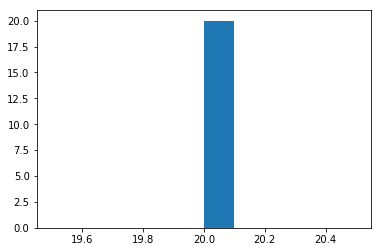

In [23]:
import matplotlib.pyplot as plt
targetDf.groupBy("points").count().rdd.values().histogram(5)
#Matplotlib

df_pd = targetDf.toPandas()
plt.hist(df_pd['points'])